In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import pickle as pkl

torch.manual_seed(100)
torch.cuda.manual_seed(100)
np.random.seed(100)
random.seed(100)

/home/derek/anaconda3/envs/timeseries/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Initial analysis

In [2]:
if torch.cuda.is_available():
    rank = 0
    torch.cuda.set_device(rank)
    current_device = torch.device("cuda", rank)
else:
    current_device = torch.device("cpu")


In [3]:
actual_test_data = pd.read_csv('test.csv')
actual_test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [4]:
VAL_DATE = '2015-05-08'
TEST_DATE = '2015-06-20'

In [5]:
data = pd.read_csv('train.csv', low_memory=False)

In [6]:
stores = pd.read_csv('store.csv')

In [7]:
full_data = data.merge(stores, on='Store')
full_data = full_data.sort_values(by='Date')

In [8]:
full_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
679363,746,2,2013-01-01,0,0,0,0,a,1,d,c,4330.0,2.0,2011.0,1,35.0,2011.0,"Mar,Jun,Sept,Dec"
155193,171,2,2013-01-01,0,0,0,0,a,1,a,a,2640.0,NaN,NaN,0,NaN,NaN,NaN
632403,694,2,2013-01-01,0,0,0,0,a,1,a,c,460.0,11.0,2012.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
361623,396,2,2013-01-01,0,0,0,0,a,1,a,c,23130.0,NaN,NaN,0,NaN,NaN,NaN


In [9]:
# Filter data by nonzero sales
full_data = full_data.loc[full_data.Open == 1].sort_values(by='Date')
full_train = full_data.loc[full_data.Date < VAL_DATE]
full_val = full_data.loc[(full_data.Date >= VAL_DATE) & (full_data.Date < TEST_DATE)]
full_test = full_data.loc[(full_data.Date >= TEST_DATE)]

In [10]:
num_variables = 1
scaler = MinMaxScaler().fit(full_train.Sales.values.reshape(-1,1))
full_train['NormSales'] = scaler.transform(full_train.Sales.values.reshape(-1,1))
full_val['NormSales'] = scaler.transform(full_val.Sales.values.reshape(-1,1))
full_test['NormSales'] = scaler.transform(full_test.Sales.values.reshape(-1,1))

/home/derek/anaconda3/envs/timeseries/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/derek/anaconda3/envs/timeseries/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/derek/anaconda3/envs/timeseries/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy 

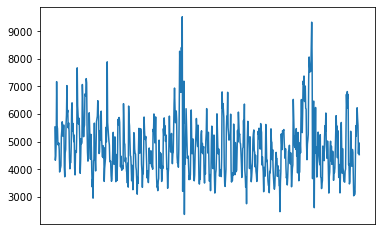

In [11]:
locator = mdates.MonthLocator()  # every month

# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

store_to_plot = 1
fig, ax = plt.subplots()

ax.plot(full_train.loc[full_train.Store == store_to_plot, 'Date'],full_train.loc[full_train.Store == store_to_plot,'Sales'])
plt.tick_params(axis='both', which='major', labelsize=10)
X = ax.xaxis
X.set_major_locator(locator)

# Specify formatter
X.set_major_formatter(fmt)
plt.show()

Text(0.5, 1.0, 'Partial Autocorrelation for store 1')

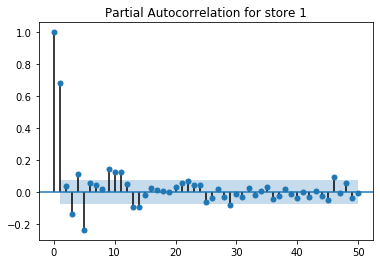

In [12]:
store_to_plot = 1
fig = plot_pacf(full_train.loc[full_train.Store == store_to_plot, 'Sales'],lags=50)
plt.title("Partial Autocorrelation for store {}".format(store_to_plot))

## Data processing

In [13]:
train_window = 12

In [14]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw+1]
        inout_seq.append(train_seq)
    return inout_seq

In [15]:
stores = [1]

In [16]:
train_inout_seq = []
for store in stores:
    this_store = full_train.loc[full_train.Store == store].sort_values(by='Date')
    this_store_sales = this_store.NormSales.values.astype(float)
    inout_seq = create_inout_sequences(this_store_sales,train_window)
    train_inout_seq += inout_seq

In [17]:
val_inout_seq = []
for store in stores:
    this_store = full_val.loc[full_val.Store == store].sort_values(by='Date')
    this_store_sales = this_store.NormSales.values.astype(float)
    inout_seq = create_inout_sequences(this_store_sales,train_window)
    val_inout_seq += inout_seq

In [18]:
class SeqDataset(Dataset):
    def __init__(self, inout_seq):
        super().__init__()

        # for each sample: [:-1] is input, [-1] is target
        self.sequences = [torch.FloatTensor(i) for i in inout_seq]
    
    def __getitem__(self, i):
        sample = self.sequences[i]
        return sample

    def __len__(self):
        return len(self.sequences)
    
def batchify(list_minibatch,num_variables=num_variables):
    inp_list = [i[:-1].view(-1,num_variables) for i in list_minibatch]
    tar_list = [i[-1:] for i in list_minibatch]

    inp_tensor = torch.stack(inp_list, dim=1)
    tar_tensor = torch.stack(tar_list, dim=0).view(-1)

    return inp_tensor, tar_tensor

In [19]:
batch_size = 1
train_dataset = SeqDataset(train_inout_seq)
train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=batchify, drop_last=False)

val_dataset = SeqDataset(val_inout_seq)
val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn = batchify, drop_last=False)

## Models

In [20]:
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_layers = 2, hidden_layer_size=64, dropout=0.2, output_size=1, batch_size=batch_size):
        super().__init__()
        self.hidden_layers = hidden_layers
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.hidden_layer_size = hidden_layer_size
        
        self.rnn = nn.RNN(input_size, hidden_layer_size, self.hidden_layers, dropout=dropout)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        hidden = self.init_hidden()
        rnn_out, _ = self.rnn(input_seq, hidden)
        predictions = self.linear(rnn_out[-1].view(self.batch_size,-1))
        return predictions.view(-1)
    
    def init_hidden(self):
        h0 = Variable(torch.randn(self.hidden_layers, self.batch_size, self.hidden_layer_size) * 0.1)
        return h0

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layers = 2, hidden_layer_size=64, dropout=0.2, output_size=1, batch_size=batch_size):
        super().__init__()
        self.hidden_layers = hidden_layers
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.hidden_layer_size = hidden_layer_size
        
        self.rnn = nn.LSTM(input_size, hidden_layer_size, self.hidden_layers, dropout=dropout)
        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = self.init_hidden()

    def forward(self, input_seq):
        hidden = self.init_hidden()
        rnn_out, _ = self.rnn(input_seq, hidden)
        predictions = self.linear(rnn_out[-1].view(self.batch_size,-1))
        return predictions.view(-1)
    
    def init_hidden(self):
        h0 = Variable(torch.randn(self.hidden_layers, self.batch_size, self.hidden_layer_size) * 0.1)
        c0 = Variable(torch.randn(self.hidden_layers, self.batch_size, self.hidden_layer_size) * 0.1)
        return h0, c0

In [22]:
def evaluate(model, val_data, loss_function, scaler=None, model_type = 'rnn', output_size=1):
    model.eval()
    val_cache = []
    for i, batch in enumerate(val_data):
        with torch.no_grad():
            seq, labels = batch
            seq = seq.to(current_device)
            labels = labels.to(current_device)

            y_pred = model(seq)
            if scaler is not None:

                y_pred = scaler.inverse_transform(y_pred.cpu().numpy().reshape(output_size,-1))
                labels = scaler.inverse_transform(labels.cpu().numpy().reshape(output_size,-1))
                loss = mean_squared_error(y_pred,labels)
                val_cache.append(loss)
            else:
                single_loss = loss_function(y_pred, labels)
                val_cache.append(single_loss.item())
    avg_val = np.mean(val_cache)
    return avg_val

In [23]:
def train(model, train_data, val_data, learning_rate = 0.001, epochs = 2, train_steps = 1600, train_log_steps = 200, val_log_steps = 800, model_type = 'rnn', scaler = None):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    avg_train_cache = []
    avg_val_cache = []
    for epoch in range(epochs):
        model.train()
        train_cache = []
        for i, batch in enumerate(train_data):
            if i < train_steps:
                seq, labels = batch
                seq = seq.to(current_device)
                labels = labels.to(current_device)
                optimizer.zero_grad()
                
                y_pred = model(seq)

                single_loss = loss_function(y_pred, labels)
                train_cache.append(single_loss.item())
                single_loss.backward()
                optimizer.step()

                if i % train_log_steps == 0 and i >0:
                    avg_train_loss = np.mean(train_cache)
                    avg_train_cache.append(avg_train_loss)

                    print("Training loss at iteration {}: {:.5}".format(i,avg_train_loss))
                    train_cache = []

                if i % val_log_steps == 0 and i > 0:
                    avg_val = evaluate(model, val_data, loss_function, scaler, model_type = model_type, output_size = model.output_size)
                    avg_val_cache.append(avg_val)
                    print("==========Val loss at iteration {}: {:.7}".format(i,avg_val))
                    model.train()
        if len(avg_train_cache) > 0:
            print(f'epoch: {epoch:3} loss: {avg_train_cache[-1]:10.8f}')
    if len(avg_train_cache) > 0:
        print(f'epoch: {epoch:3} loss: {avg_train_cache[-1]:10.10f}')
    return model, avg_train_cache, avg_val_cache

#### Example training and testing

In [24]:
model = RNN(hidden_layers = 2, hidden_layer_size=32, dropout=0.1, output_size = 1)
model.to(current_device)
model, avg_train_cache, avg_val_cache = train(model, train_data, val_data, learning_rate = 0.0005, epochs=10)

Training loss at iteration 200: 0.0023052
Training loss at iteration 400: 0.00096445
Training loss at iteration 600: 0.00068257
epoch:   0 loss: 0.00068257
Training loss at iteration 200: 0.00085681
Training loss at iteration 400: 0.00088477
Training loss at iteration 600: 0.00066989
epoch:   1 loss: 0.00066989
Training loss at iteration 200: 0.00065869
Training loss at iteration 400: 0.00067015
Training loss at iteration 600: 0.00051792
epoch:   2 loss: 0.00051792
Training loss at iteration 200: 0.00052851
Training loss at iteration 400: 0.00051079
Training loss at iteration 600: 0.00070202
epoch:   3 loss: 0.00070202
Training loss at iteration 200: 0.00051775
Training loss at iteration 400: 0.0005555
Training loss at iteration 600: 0.00054974
epoch:   4 loss: 0.00054974
Training loss at iteration 200: 0.00049887
Training loss at iteration 400: 0.00052327
Training loss at iteration 600: 0.00055821
epoch:   5 loss: 0.00055821
Training loss at iteration 200: 0.00063906
Training loss at 

Text(0.5, 1.0, 'Learning curves')

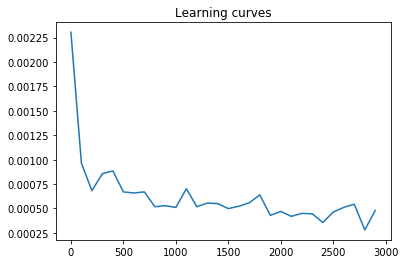

In [25]:
plt.plot(np.arange(len(avg_train_cache)) * 100, avg_train_cache,label='Avg Train')
plt.plot(np.arange(len(avg_val_cache))*300, avg_val_cache,label='Val')
plt.title('Learning curves')

In [26]:
def rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def rmspe(actual, predicted):
    mask = actual != 0
    return np.sqrt(np.nanmean(((actual[mask]-predicted[mask])/actual[mask])**2))

In [35]:
def full_predict(model, future_pred_window, train_window, test_actuals, test_sales, test_otherinputs = None, num_variables=1, model_type = 'rnn'):
    model.eval()

    for i in range(future_pred_window):
        sales = test_sales[i:i+train_window]
        seq = torch.FloatTensor(sales).view(train_window,1,num_variables).to(current_device)
        with torch.no_grad():
            test_sales = np.append(test_sales,model(seq).item()).reshape(-1,1)
    
    # add column for scaling
    test_sales_for_scaling = np.zeros((future_pred_window,num_variables))
    test_sales_for_scaling[:,0] = test_sales[train_window:].reshape(-1)
    actual_predictions = scaler.inverse_transform(test_sales_for_scaling)[:,0]
    check = test_actuals[:future_pred_window,0]
    
    
    return actual_predictions, check, rmse(check, actual_predictions), rmspe(check, actual_predictions)

In [36]:
train_window=12
test_sales = full_train.loc[full_train.Store == 1,'NormSales'].values[-train_window:].reshape(-1,1)
test_actuals = full_val.loc[full_val.Store == 1, 'Sales'].values.reshape(-1,1)
future_pred_window = len(test_actuals)

In [38]:
actual_predictions, test_actuals, rmse_error, rmspe_error = full_predict(model,future_pred_window, train_window, test_actuals, test_sales, num_variables)

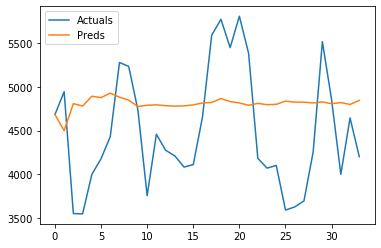

In [39]:
plt.plot(range(future_pred_window),test_actuals, label = 'Actuals')
plt.plot(range(future_pred_window), actual_predictions, label = 'Preds')
plt.legend()
plt.show()

In [43]:
stores = [1,2,3,4,5,13,15,18,21,85,259,262]
full_errors = []
for store in stores:
    test_sales = full_train.loc[full_train.Store == store,'NormSales'].values[-train_window:].reshape(-1,1)

    test_actuals = full_val.loc[full_val.Store == store, 'Sales'].values.reshape(-1,1)
    future_pred_window = len(test_actuals)
    actual_predictions, test_actuals, rmse_error, rmspe_error = full_predict(model,future_pred_window, train_window, test_actuals, test_sales, num_variables)
    full_errors.append(rmspe_error)

In [44]:
np.mean(full_errors)

0.40693582720471549

In [45]:
actual_predictions

array([ 10061.80304438,   5028.74410886,   3320.93219422,   3489.36507098,
         2982.97590546,   3507.47891875,   4405.77009241,   5163.69351524,
         5530.44224191,   5612.21968961,   5483.5492273 ,   5207.67035788,
         4973.37376964,   4756.75452657,   4694.07183133,   4664.17501013,
         4685.62681888,   4744.45455866,   4787.92306186,   4848.22071618,
         4861.94414991,   4872.27134538,   4847.11979491,   4815.91865896,
         4787.00966649,   4813.89568727,   4807.38132606,   4771.94527833,
         4777.39160742,   4804.51246832,   4809.63509886,   4819.29066311,
         4830.42681645,   4816.971112  ,   4845.468413  ,   4821.44172941,
         4837.27526225,   4794.96884261,   4836.54766177,   4785.51638333,
         4797.21453737,   4792.76642306,   4815.95385613])

## Hyperparameter tuning

In [47]:
stores = [1,2,3,4,5,13,15,18,21,85,259,262]

In [48]:
dropouts = [0, 0.1,0.2]
hidden_layer_sizes = [16,32,64]
learning_rates = [0.00005, 0.0005, 0.005, 0.01]
training_windows = [4,12]
train_steps = [4800]
rnn_options = {'best_val':10**32,
           'best_tw':0,
           'best_lr':0,
           'best_size':0,
           'best_dropout':0}
rnn_history = pd.DataFrame(columns=['dropout','hidden_layer_size','learning_rate','training_window','train_steps','rmse'])

In [ ]:
for tw in training_windows:
    train_inout_seq = []
    for store in stores:
        this_store = full_train.loc[full_train.Store == store].sort_values(by='Date')
        this_store_sales = this_store.NormSales.values.astype(float)
        inout_seq = create_inout_sequences(this_store_sales,tw)
        train_inout_seq += inout_seq
        
    val_inout_seq = []
    for store in stores:
        this_store = full_val.loc[full_val.Store == store].sort_values(by='Date')
        this_store_sales = this_store.NormSales.values.astype(float)
        inout_seq = create_inout_sequences(this_store_sales,train_window)
        val_inout_seq += inout_seq
        
    batch_size = 1
    train_dataset = SeqDataset(train_inout_seq)
    train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=batchify, drop_last=False)

    val_dataset = SeqDataset(val_inout_seq)
    val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn = batchify, drop_last=False)
        
    for learning_rate in learning_rates:
        for size in hidden_layer_sizes:
            for dropout in dropouts:
                for train_step in train_steps:
                    print("Running model with training window size: {}\n learning rate: {}\n hidden size: {}\n dropout: {}\n\n".format(tw,learning_rate, size, dropout))
                    model = RNN(hidden_layers = 2, hidden_layer_size=size, dropout=dropout)
                    model.to(current_device)
                    loss_function = nn.MSELoss()
                    model, avg_train_cache, avg_val_cache = train(model,train_data, val_data, learning_rate = learning_rate, epochs=1, train_steps = train_step, model_type = 'rnn', scaler = scaler)

                    avg_val = evaluate(model, val_data, loss_function, scaler, model_type = 'rnn')
                    
                    current_options = pd.DataFrame([[dropout, size, learning_rate, tw, train_step, np.sqrt(avg_val)]], columns=['dropout','hidden_layer_size','learning_rate','training_window','train_steps','rmse'])
                    rnn_history = rnn_history.append(current_options,ignore_index=True)

                    print("======================The validation RMSE is : {:.7}".format(np.sqrt(avg_val)))

                    if np.sqrt(avg_val) < rnn_options['best_val'] :
                        rnn_options['best_val'] = np.sqrt(avg_val)
                        rnn_options['best_tw'] = tw
                        rnn_options['best_lr'] = learning_rate
                        rnn_options['best_size'] = size
                        rnn_options['best_dropout'] = dropout
                        rnn_options['best_trainsteps'] = train_step
                        torch.save(model, 'best_rnn.pt')



In [42]:
pkl.dump( rnn_options, open( "rnn_options.p", "wb" ) )
pkl.dump( rnn_history, open( "rnn_exogenous_history.p", "wb" ) )

rnn_options

{'best_val': 1721.4926,
 'best_tw': 12,
 'best_lr': 0.0005,
 'best_size': 32,
 'best_dropout': 0.1,
 'best_trainsteps': 4800}

In [43]:
dropouts = [0, 0.1,0.2]
hidden_layer_sizes = [16,32,64]
learning_rates = [0.00005, 0.0005, 0.005, 0.01]
training_windows = [4,12]
train_steps = [4800]
lstm_options = {'best_val':10**32,
           'best_tw':0,
           'best_lr':0,
           'best_size':0,
           'best_dropout':0}
lstm_history = pd.DataFrame(columns=['dropout','hidden_layer_size','learning_rate','training_window','train_steps','rmse'])

In [ ]:
for tw in training_windows:
    train_inout_seq = []
    
    for store in stores:
        this_store = full_train.loc[full_train.Store == store].sort_values(by='Date')
        this_store_sales = this_store.NormSales.values.astype(float)
        inout_seq = create_inout_sequences(this_store_sales,tw)
        train_inout_seq += inout_seq
        
    val_inout_seq = []
    for store in stores:
        this_store = full_val.loc[full_val.Store == store].sort_values(by='Date')
        this_store_sales = this_store.NormSales.values.astype(float)
        inout_seq = create_inout_sequences(this_store_sales,train_window)
        val_inout_seq += inout_seq
        
    batch_size = 1
    train_dataset = SeqDataset(train_inout_seq)
    train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=batchify, drop_last=False)

    val_dataset = SeqDataset(val_inout_seq)
    val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn = batchify, drop_last=False)
        
    for learning_rate in learning_rates:
        for size in hidden_layer_sizes:
            for dropout in dropouts:
                for train_step in train_steps:
                    print("Running model with training window size: {}\n learning rate: {}\n hidden size: {}\n dropout: {}\n\n".format(tw,learning_rate, size, dropout))
                    model = LSTM(hidden_layers = 2, hidden_layer_size=size, dropout=dropout)
                    model.to(current_device)
                    model, avg_train_cache, avg_val_cache = train(model,train_data, val_data, learning_rate = learning_rate, epochs=1, train_steps = train_step, model_type='lstm', scaler = scaler)

                    avg_val = evaluate(model, val_data, loss_function, scaler, model_type='lstm')
                    
                    current_options = pd.DataFrame([[dropout, size, learning_rate, tw, train_step, np.sqrt(avg_val)]], columns=['dropout','hidden_layer_size','learning_rate','training_window','train_steps','rmse'])
                    lstm_history = lstm_history.append(current_options,ignore_index=True)
                    
                    print("======================The validation RMSE is : {:.5}".format(np.sqrt(avg_val)))

                    if np.sqrt(avg_val) < lstm_options['best_val'] :
                        lstm_options['best_val'] = np.sqrt(avg_val)
                        lstm_options['best_tw'] = tw
                        lstm_options['best_lr'] = learning_rate
                        lstm_options['best_size'] = size
                        lstm_options['best_dropout'] = dropout
                        lstm_options['best_trainsteps'] = train_step

                        torch.save(model, 'best_lstm.pt')



In [45]:
pkl.dump( lstm_options, open( "lstm_options.p", "wb" ) )
pkl.dump( lstm_history, open( "lstm_exogenous_history.p", "wb" ) )
lstm_options

{'best_val': 1712.8219,
 'best_tw': 4,
 'best_lr': 0.01,
 'best_size': 32,
 'best_dropout': 0.1,
 'best_trainsteps': 4800}

In [30]:
# tw = 12
# learning_rate = 0.005
# size = 16
# dropout = 0.1
# train_steps = 4000
# train_inout_seq = []

# loss_function = nn.MSELoss()

# for store in stores:
#     this_store = full_train.loc[full_train.Store == store].sort_values(by='Date')
#     this_store_sales = this_store.NormSales.values.astype(float)
#     inout_seq = create_inout_sequences(this_store_sales,tw)
#     train_inout_seq += inout_seq

# val_inout_seq = []
# for store in stores:
#     this_store = full_val.loc[full_val.Store == store].sort_values(by='Date')
#     this_store_sales = this_store.NormSales.values.astype(float)
#     inout_seq = create_inout_sequences(this_store_sales,train_window)
#     val_inout_seq += inout_seq

# batch_size = 1
# train_dataset = SeqDataset(train_inout_seq)
# train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=batchify, drop_last=False)

# val_dataset = SeqDataset(val_inout_seq)
# val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn = batchify, drop_last=False)


# print("Running model with training window size: {}\n learning rate: {}\n hidden size: {}\n dropout: {}\n\n".format(tw,learning_rate, size, dropout))
# model = LSTM(hidden_layers = 2, hidden_layer_size=size, dropout=dropout)
# model.to(current_device)
# model, avg_train_cache, avg_val_cache = train(model,train_data, val_data, learning_rate = learning_rate, epochs=1, train_steps = train_steps, model_type='lstm', scaler = scaler)

# avg_val = evaluate(model, val_data, loss_function, scaler, model_type='lstm')

# print("======================The validation RMSE is : {:.5}".format(np.sqrt(avg_val)))
# torch.save(model, 'best_lstm.pt')



Running model with training window size: 12
 learning rate: 0.005
 hidden size: 16
 dropout: 0


Training loss at iteration 200: 0.0063221
Training loss at iteration 400: 0.0058182
Training loss at iteration 600: 0.0037765
Training loss at iteration 800: 0.0067444
==========Val loss at iteration 800: 6.245566e+06
Training loss at iteration 1000: 0.0028978
Training loss at iteration 1200: 0.0045507
Training loss at iteration 1400: 0.0018833
Training loss at iteration 1600: 0.0022169
==========Val loss at iteration 1600: 3.513491e+06
Training loss at iteration 1800: 0.003499
Training loss at iteration 2000: 0.0023348
Training loss at iteration 2200: 0.002245
Training loss at iteration 2400: 0.0027199
==========Val loss at iteration 2400: 3.452738e+06
Training loss at iteration 2600: 0.0023393
Training loss at iteration 2800: 0.004636
Training loss at iteration 3000: 0.002513
Training loss at iteration 3200: 0.0035952
==========Val loss at iteration 3200: 3.57785e+06
Training loss at iter

/home/derek/anaconda3/envs/timeseries/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/derek/anaconda3/envs/timeseries/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Evaluation

In [49]:
def full_predict(model, future_pred_window, train_window, test_actuals, test_sales, test_otherinputs = None, num_variables=1, model_type = 'rnn'):
    model.eval()

    for i in range(future_pred_window):
        sales = test_sales[i:i+train_window]
        seq = torch.FloatTensor(sales).view(train_window,1,num_variables).to(current_device)
        with torch.no_grad():
            test_sales = np.append(test_sales,model(seq).item()).reshape(-1,1)
    
    # add column for scaling
    test_sales_for_scaling = np.zeros((future_pred_window,num_variables))
    test_sales_for_scaling[:,0] = test_sales[train_window:].reshape(-1)
    actual_predictions = scaler.inverse_transform(test_sales_for_scaling)[:,0]
    check = test_actuals[:future_pred_window,0]
    
    
    return actual_predictions, check, rmse(check, actual_predictions), rmspe(check, actual_predictions)

In [50]:
def onestep_predict(model, future_pred_window, train_window, test_actuals, test_sales, test_otherinputs = None, num_variables=1, model_type = 'rnn'):
    model.eval()
    one_step_predictions = []
    for i in range(future_pred_window):
        sales = test_sales[i:i+train_window]
        seq = torch.FloatTensor(sales).view(train_window,1,num_variables).to(current_device)
        with torch.no_grad():
            one_step_predictions.append(model(seq).item())
    one_step_predictions = np.array(one_step_predictions).reshape(-1,1)
    
    # add column for scaling
    test_sales_for_scaling = np.zeros((future_pred_window,num_variables))
    test_sales_for_scaling[:,0] = one_step_predictions.reshape(-1)
    actual_predictions = scaler.inverse_transform(test_sales_for_scaling)[:,0]
    check = test_actuals[:future_pred_window,0]
    
    
    return actual_predictions, check, rmse(check, actual_predictions), rmspe(check, actual_predictions)

### RNN

In [52]:
rnn_options = pkl.load( open( "rnn_options.p", "rb" ) )
model = torch.load('best_rnn.pt')

loss_function = nn.MSELoss()
tw = rnn_options['best_tw']
rnn_options

{'best_val': 1721.4926,
 'best_tw': 12,
 'best_lr': 0.0005,
 'best_size': 32,
 'best_dropout': 0.1,
 'best_trainsteps': 4800}

In [53]:
stores = [1,2,3,4,5,13,15,18,21,85,259,262]
store_to_plot = np.random.choice(stores,1)[0]
print("Plotting Store {}".format(store_to_plot))

future_pred_window = len(full_val.loc[full_val.Store == store_to_plot, 'NormSales'])
print("Future prediction window: {}".format(future_pred_window))

initial_test_sales = full_train.loc[full_train.Store == store_to_plot,'NormSales'].values[-tw:].reshape(-1,1)
test_actuals = full_val.loc[full_val.Store == store_to_plot, 'NormSales'].values[:future_pred_window].reshape(-1,1)
test_sales = np.append(initial_test_sales, test_actuals)
test_actuals = full_val.loc[full_val.Store == store_to_plot, 'Sales'].values[:future_pred_window].reshape(-1,1)

Plotting Store 21
Future prediction window: 34


In [54]:
actual_predictions, check, rmse_error, rmspe_error = onestep_predict(model, future_pred_window, tw, test_actuals, test_sales, model_type = 'lstm')

In [55]:
actual_predictions

array([ 5431.54685321,  6101.77018347,  6487.34016329,  4922.49135792,
        5166.99916407,  5535.79394254,  6221.11743513,  5659.58757749,
        6482.11424926,  7267.81718165,  6498.08799377,  6042.92513362,
        6649.89280489,  6129.75597152,  6176.7061094 ,  5768.15526351,
        4429.74398024,  5172.11602458,  5939.2862052 ,  7435.50399384,
        7819.36546847,  7476.04247701,  7375.46454826,  6074.74337402,
        4661.33788754,  4743.76417485,  3923.09660599,  4593.65488635,
        5051.17278329,  6219.71127939,  8751.41649684,  8119.64809278,
        6378.92769101,  6431.88211966])

RMSPE errror: 0.317917
RMSE errror: 1482.88


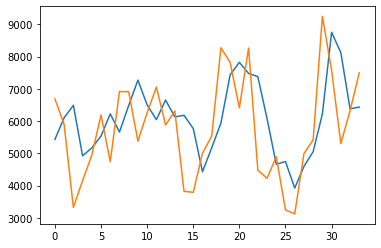

In [56]:
plt.plot(np.arange(len(actual_predictions)), actual_predictions)
plt.plot(np.arange(len(actual_predictions)), check)
print("RMSPE errror: {:.6}".format(rmspe_error))
print("RMSE errror: {:.6}".format(rmse_error))

In [57]:
test_sales = full_train.loc[full_train.Store == store_to_plot,'NormSales'].values[-tw:].reshape(-1,1)
test_actuals = full_val.loc[full_val.Store == store_to_plot, 'Sales'].values[:future_pred_window].reshape(-1,1)
actual_predictions, check, rmse_error, mape_error = full_predict(model, future_pred_window, train_window, test_actuals, test_sales, num_variables, model_type='lstm')

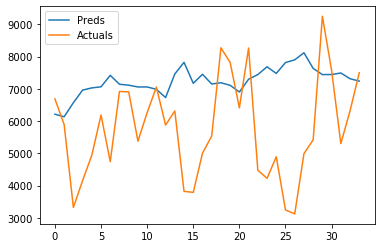

MAPE errror: 0.56532
RMSE errror: 2238.08


In [58]:
plt.plot(range(future_pred_window), actual_predictions, label = 'Preds')
plt.plot(range(future_pred_window),check, label = 'Actuals')
plt.legend()
plt.show()
print("MAPE errror: {:.6}".format(mape_error))
print("RMSE errror: {:.6}".format(rmse_error))

In [60]:
full_rmse_errors = []
full_rmspe_errors = []
for store in stores:
    test_sales = full_train.loc[full_train.Store == store,'NormSales'].values[-tw:].reshape(-1,1)

    test_actuals = full_val.loc[full_val.Store == store, 'Sales'].values.reshape(-1,1)
    future_pred_window = len(test_actuals)
    actual_predictions, test_actuals, rmse_error, rmspe_error = full_predict(model,future_pred_window, tw, test_actuals, test_sales, num_variables)
    full_rmse_errors.append(rmse_error)
    full_rmspe_errors.append(mape_error)
print("Average RMSE error: {:.6}".format(np.mean(full_rmse_errors)))
print("Average RMSPE error: {:.6}".format(np.mean(full_mape_errors)))

Average RMSE error: 3394.1
Average RMSPE error: 0.449943


### LSTM

In [61]:
lstm_options = pkl.load( open( "lstm_options.p", "rb" ) )
model = torch.load('best_lstm.pt')

loss_function = nn.MSELoss()
tw = lstm_options['best_tw']

In [67]:
stores = [1,2,3,4,5,13,15,18,21,85,259,262]
store_to_plot = np.random.choice(stores,1)[0]
print("Plotting Store {}".format(store_to_plot))

future_pred_window = len(full_val.loc[full_val.Store == store_to_plot, 'NormSales'])
print("Future prediction window: {}".format(future_pred_window))

initial_test_sales = full_train.loc[full_train.Store == store_to_plot,'NormSales'].values[-tw:].reshape(-1,1)
test_actuals = full_val.loc[full_val.Store == store_to_plot, 'NormSales'].values[:future_pred_window].reshape(-1,1)
test_sales = np.append(initial_test_sales, test_actuals)
test_actuals = full_val.loc[full_val.Store == store_to_plot, 'Sales'].values[:future_pred_window].reshape(-1,1)

Plotting Store 4
Future prediction window: 35


In [68]:
actual_predictions, check, rmse_error, rmspe_error = onestep_predict(model, future_pred_window, tw, test_actuals, test_sales, model_type = 'lstm')

RMSPE errror: 0.143024
RMSE errror: 1460.68


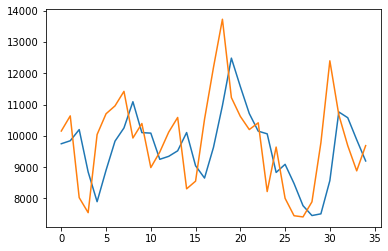

In [69]:
plt.plot(np.arange(len(actual_predictions)), actual_predictions)
plt.plot(np.arange(len(actual_predictions)), check)
print("RMSPE errror: {:.6}".format(rmspe_error))
print("RMSE errror: {:.6}".format(rmse_error))

In [72]:
test_sales = full_train.loc[full_train.Store == store_to_plot,'NormSales'].values[-tw:].reshape(-1,1)
test_actuals = full_val.loc[full_val.Store == store_to_plot, 'Sales'].values[:future_pred_window].reshape(-1,1)
actual_predictions, check, rmse_error, rmspe_error = full_predict(model, future_pred_window, tw, test_actuals, test_sales, num_variables, model_type='lstm')

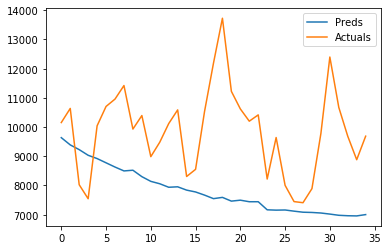

RMSPE errror: 0.233967
RMSE errror: 2569.88


In [73]:
plt.plot(range(future_pred_window), actual_predictions, label = 'Preds')
plt.plot(range(future_pred_window),check, label = 'Actuals')
plt.legend()
plt.show()
print("RMSPE errror: {:.6}".format(rmspe_error))
print("RMSE errror: {:.6}".format(rmse_error))

In [75]:
full_rmse_errors = []
full_rmspe_errors = []
for store in stores:
    test_sales = full_train.loc[full_train.Store == store,'NormSales'].values[-tw:].reshape(-1,1)

    test_actuals = full_val.loc[full_val.Store == store, 'Sales'].values.reshape(-1,1)
    future_pred_window = len(test_actuals)
    actual_predictions, test_actuals, rmse_error, rmspe_error = full_predict(model,future_pred_window, tw, test_actuals, test_sales, num_variables)
    full_rmse_errors.append(rmse_error)
    full_rmspe_errors.append(rmspe_error)
print("Average RMSE error: {:.6}".format(np.mean(full_rmse_errors)))
print("Average MAPE error: {:.6}".format(np.mean(full_rmspe_errors)))

Average RMSE error: 3148.39
Average MAPE error: 0.424464


## Single-store

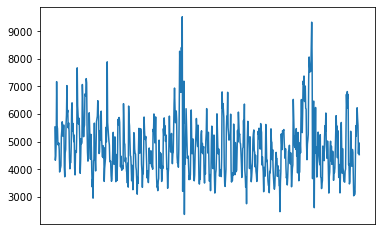

In [76]:
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

store_to_plot = 1
fig, ax = plt.subplots()

ax.plot(full_train.loc[full_train.Store == store_to_plot, 'Date'],full_train.loc[full_train.Store == store_to_plot,'Sales'])
plt.tick_params(axis='both', which='major', labelsize=10)
X = ax.xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
plt.show()

In [77]:
differenced_data = []
sorted_data = full_train.loc[full_train.Store == store_to_plot].sort_values(by='Date')
for i in range(len(sorted_data)-1):
    differenced_data.append(sorted_data.iloc[i+1].Sales - sorted_data.iloc[i].Sales)

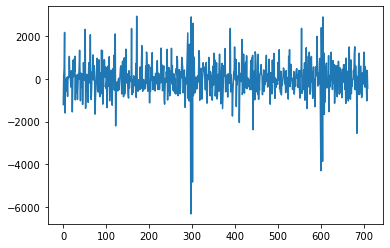

In [78]:
plt.plot(np.arange(len(differenced_data)), differenced_data)

In [79]:
sorted_data.NormSales.diff()

940         NaN
939   -0.031068
938    0.004106
937    0.013197
935    0.056273
934   -0.041217
933   -0.002815
932   -0.014953
931   -0.000284
930    0.001834
928   -0.006069
927   -0.021099
926    0.002789
925    0.000930
924    0.002143
923    0.027245
921    0.005475
920    0.008419
919   -0.003667
918   -0.009891
917    0.010098
916    0.000310
914   -0.039848
913   -0.008522
912    0.022623
911    0.002789
910    0.023862
909    0.008703
907    0.027426
906   -0.025386
         ...   
122   -0.013119
121    0.015753
120   -0.006250
118    0.003486
115   -0.065751
114    0.000801
113   -0.018775
112    0.002118
111    0.016115
109    0.031093
108   -0.018827
107   -0.013894
106    0.000155
105    0.015547
104   -0.003202
102   -0.022519
101   -0.017690
100    0.007283
99    -0.006276
98     0.003151
97     0.028924
95     0.032462
94    -0.009710
93     0.014875
92     0.011699
90    -0.009762
88    -0.006689
87    -0.026522
86     0.010227
85    -0.011131
Name: NormSales, Length:

In [80]:
tw = 12
learning_rate = 0.0005
size = 32
num_layers = 2
dropout = 0.1
num_epochs = 10
train_steps = 4000
train_inout_seq = []

loss_function = nn.MSELoss()
stores = [13]
for store in stores:
    this_store = full_train.loc[full_train.Store == store].sort_values(by='Date')
    this_store_sales = this_store.NormSales.values.astype(float)
    inout_seq = create_inout_sequences(this_store_sales,tw)
    train_inout_seq += inout_seq

val_inout_seq = []
for store in stores:
    this_store = full_val.loc[full_val.Store == store].sort_values(by='Date')
    this_store_sales = this_store.NormSales.values.astype(float)
    inout_seq = create_inout_sequences(this_store_sales,tw)
    val_inout_seq += inout_seq

batch_size = 1
train_dataset = SeqDataset(train_inout_seq)
train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=batchify, drop_last=False)

val_dataset = SeqDataset(val_inout_seq)
val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn = batchify, drop_last=False)


print("Running model with training window size: {}\n learning rate: {}\n hidden size: {}\n dropout: {}\n\n".format(tw,learning_rate, size, dropout))
model = RNN(hidden_layers = num_layers, hidden_layer_size=size, dropout=dropout)
model.to(current_device)
model, avg_train_cache, avg_val_cache = train(model,train_data, val_data, learning_rate = learning_rate, epochs=num_epochs, train_steps = train_steps, model_type='lstm', scaler = scaler)

avg_val = evaluate(model, val_data, loss_function, scaler, model_type='lstm')

print("======================The validation RMSE is : {:.5}".format(np.sqrt(avg_val)))


Running model with training window size: 12
 learning rate: 0.0005
 hidden size: 32
 dropout: 0.1


Training loss at iteration 200: 0.0029132
Training loss at iteration 400: 0.0019239
epoch:   0 loss: 0.00192392
Training loss at iteration 200: 0.0017702
Training loss at iteration 400: 0.0018687
epoch:   1 loss: 0.00186875
Training loss at iteration 200: 0.0011795
Training loss at iteration 400: 0.0014942
epoch:   2 loss: 0.00149418
Training loss at iteration 200: 0.0013636
Training loss at iteration 400: 0.0013099
epoch:   3 loss: 0.00130990
Training loss at iteration 200: 0.0013069
Training loss at iteration 400: 0.0011662
epoch:   4 loss: 0.00116616
Training loss at iteration 200: 0.0013219
Training loss at iteration 400: 0.0010204
epoch:   5 loss: 0.00102037
Training loss at iteration 200: 0.0010457
Training loss at iteration 400: 0.0011416
epoch:   6 loss: 0.00114161
Training loss at iteration 200: 0.0014133
Training loss at iteration 400: 0.0010547
epoch:   7 loss: 0.00105472
Trai

In [81]:
store_to_plot = 13
test_sales = full_train.loc[full_train.Store == store_to_plot,'NormSales'].values[-tw:].reshape(-1,1)
test_actuals = full_val.loc[full_val.Store == store_to_plot, 'Sales'].values.reshape(-1,1)
future_pred_window = len(test_actuals)
actual_predictions, check, rmse_error, rmspe_error = full_predict(model, future_pred_window, tw, test_actuals, test_sales, num_variables, model_type='lstm')

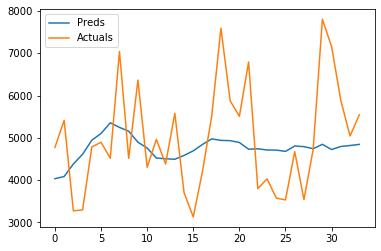

RMSE errror: 1235.57
RMSPE errror: 0.237442


In [82]:
plt.plot(range(future_pred_window), actual_predictions, label = 'Preds')
plt.plot(range(future_pred_window),check, label = 'Actuals')
plt.legend()
plt.show()
print("RMSE errror: {:.6}".format(rmse_error))
print("RMSPE errror: {:.6}".format(rmspe_error))

In [83]:
future_pred_window = len(full_val.loc[full_val.Store == store_to_plot, 'NormSales'])
print("Future prediction window: {}".format(future_pred_window))

initial_test_sales = full_train.loc[full_train.Store == store_to_plot,'NormSales'].values[-tw:].reshape(-1,1)
test_actuals = full_val.loc[full_val.Store == store_to_plot, 'NormSales'].values[:future_pred_window].reshape(-1,1)
test_sales = np.append(initial_test_sales, test_actuals)
test_actuals = full_val.loc[full_val.Store == store_to_plot, 'Sales'].values[:future_pred_window].reshape(-1,1)

Future prediction window: 34


In [84]:
actual_predictions, check, rmse_error, rmspe_error = onestep_predict(model, future_pred_window, tw, test_actuals, test_sales, model_type = 'lstm')

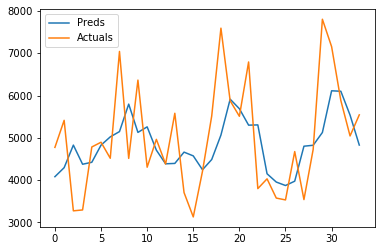

RMSE errror: 1102.28
RMSPE errror: 0.221826


In [85]:
plt.plot(range(future_pred_window), actual_predictions, label = 'Preds')
plt.plot(range(future_pred_window),check, label = 'Actuals')
plt.legend()
plt.show()
print("RMSE errror: {:.6}".format(rmse_error))
print("RMSPE errror: {:.6}".format(rmspe_error))

## Store subset

In [87]:
stores = [1,2,3,4,5,13,15,18,21,85,259,262]
tw = 12
norm_columns = ['NormSales']
num_variables = 1
learning_rate = 0.0005
num_layers = 2
size = 32
num_epochs = 10
val_steps = 1000
train_log_steps = 600
full_rmse_error = []
full_rmspe_error = []
for the_store in stores:
    these_stores = [the_store]
    print("Loading train data")
    train_inout_seq = []
    for store in these_stores:
        this_store = full_train.loc[full_train.Store == store].sort_values(by='Date')
        this_store_sales = this_store[norm_columns].values.astype(float)
        inout_seq = create_inout_sequences(this_store_sales,tw)
        train_inout_seq += inout_seq

    print("Loading val data")
    val_inout_seq = []
    for store in these_stores:
        this_store = full_val.loc[full_val.Store == store].sort_values(by='Date')
        this_store_sales = this_store[norm_columns].values.astype(float)
        inout_seq = create_inout_sequences(this_store_sales,tw)
        val_inout_seq += inout_seq

    batch_size = 1
    train_dataset = SeqDataset(train_inout_seq)
    train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda b: batchify(b,num_variables), drop_last=False)

    val_dataset = SeqDataset(val_inout_seq)
    val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn = lambda b: batchify(b,num_variables), drop_last=False)

    print("Running model with training window size: {}\n learning rate: {}\n hidden size: {}\n dropout: {}\n\n".format(tw,learning_rate, size, dropout))
    model = RNN(input_size = num_variables, hidden_layers = num_layers, hidden_layer_size=size, dropout=dropout, output_size = 1)
    model.to(current_device)
    model, avg_train_cache, avg_val_cache = train(model,train_data, val_data, learning_rate = learning_rate, epochs=num_epochs, train_log_steps = train_log_steps, val_log_steps = val_steps, train_steps = 4000, model_type='lstm', scaler = None)

    avg_val = evaluate(model, val_data, loss_function, scaler, model_type='lstm')
    initial_test_sales = full_val.loc[full_val.Store == the_store,'NormSales'].values[-tw:].reshape(-1,1)
    test_sales = initial_test_sales.reshape(-1,1)

    test_otherinputs = None
    test_actuals = full_test.loc[full_test.Store == the_store, 'Sales'].values.reshape(-1,1)
    future_pred_window = len(test_actuals)
    actual_predictions, check, rmse_error, rmspe_error = full_predict(model,future_pred_window, tw, test_actuals, test_sales, test_otherinputs = test_otherinputs, num_variables=num_variables)
    full_rmse_error.append(rmse_error)
    full_rmspe_error.append(rmspe_error)
    
print("Mean RMSE: {:.6f}".format(np.mean(full_rmse_error)))
print("Mean RMSPE: {:.6f}".format(np.mean(full_rmspe_error)))

Loading train data
Loading val data
Running model with training window size: 12
 learning rate: 0.0005
 hidden size: 32
 dropout: 0.1


Training loss at iteration 600: 0.00099506
epoch:   0 loss: 0.00099506
Training loss at iteration 600: 0.00069356
epoch:   1 loss: 0.00069356
Training loss at iteration 600: 0.00056823
epoch:   2 loss: 0.00056823
Training loss at iteration 600: 0.00051506
epoch:   3 loss: 0.00051506
Training loss at iteration 600: 0.0005129
epoch:   4 loss: 0.00051290
Training loss at iteration 600: 0.00045701
epoch:   5 loss: 0.00045701
Training loss at iteration 600: 0.00048419
epoch:   6 loss: 0.00048419
Training loss at iteration 600: 0.00045685
epoch:   7 loss: 0.00045685
Training loss at iteration 600: 0.00043051
epoch:   8 loss: 0.00043051
Training loss at iteration 600: 0.00045447
epoch:   9 loss: 0.00045447
epoch:   9 loss: 0.0004544658
Loading train data
Loading val data
Running model with training window size: 12
 learning rate: 0.0005
 hidden size: 32
 drop